# Train Channel Reduction

- Train deep classifiers for the EEG-based diagnostic classification with channel reduction.
    - CAUEEG-Dementia benchmark: Classification of **Normal**, **MCI**, and **Dementia** symptoms
    - CAUEEG-Abnormal benchmark: Classification of **Normal** and **Abnormal** symptoms    

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%cd ..

C:\Users\Minjae\Desktop\EEG_Project


In [2]:
# Load some packages
import hydra
from omegaconf import OmegaConf
import wandb
import pprint
from copy import deepcopy
import itertools
from tqdm.auto import tqdm

# custom package
from run_train import check_device_env
from run_train import prepare_and_run_train

---

## Specify the dataset, model, and train setting

In [3]:
script = "data=caueeg-dementia data.EKG=O data.awgn=0 data.awgn_age=0 data.mgn=0 data.photic=O data.seq_length=2000 model=1D-ResNet-18 model.activation=gelu model.dropout=0.3 model.fc_stages=3 model.use_age=conv train.criterion=multi-bce train.lr_scheduler_type=cosine_decay_with_warmup_half train.mixup=0.2 train.weight_decay=0.04394746639552375 ++train.project=caueeg-task2-ablation ++train.base_lr=0.00046936536527944847 ++train.search_lr=False"
print(script)

data=caueeg-dementia data.EKG=O data.awgn=0 data.awgn_age=0 data.mgn=0 data.photic=O data.seq_length=2000 model=1D-ResNet-18 model.activation=gelu model.dropout=0.3 model.fc_stages=3 model.use_age=conv train.criterion=multi-bce train.lr_scheduler_type=cosine_decay_with_warmup_half train.mixup=0.2 train.weight_decay=0.04394746639552375 ++train.project=caueeg-task2-ablation ++train.base_lr=0.00046936536527944847 ++train.search_lr=False


In [4]:
add_configs_base = []

for seg in script.split(" "):
    if 'train.project' in seg:
        continue
    elif "." in seg and "++" not in seg:
        seg = "++" + seg
    add_configs_base.append(seg)

add_configs_base.append("++model.base_model=2s1700lg")
add_configs_base.append("++train.project=caueeg-dementia-channel-reduction")
add_configs_base.append("++train.device=cuda:3")
add_configs_base.append("++train.total_samples=1.0e+7")

pprint.pprint(add_configs_base)

['data=caueeg-dementia',
 '++data.EKG=O',
 '++data.awgn=0',
 '++data.awgn_age=0',
 '++data.mgn=0',
 '++data.photic=O',
 '++data.seq_length=2000',
 'model=1D-ResNet-18',
 '++model.activation=gelu',
 '++model.dropout=0.3',
 '++model.fc_stages=3',
 '++model.use_age=conv',
 '++train.criterion=multi-bce',
 '++train.lr_scheduler_type=cosine_decay_with_warmup_half',
 '++train.mixup=0.2',
 '++train.weight_decay=0.04394746639552375',
 '++train.base_lr=0.00046936536527944847',
 '++train.search_lr=False',
 '++model.base_model=2s1700lg',
 '++train.project=caueeg-dementia-channel-reduction',
 '++train.device=cuda:3',
 '++train.total_samples=1.0e+7']


---

## Initializing configurations using Hydra and Train

In [5]:
signal_header = ["Fp1-AVG", "F3-AVG", "C3-AVG", "P3-AVG", "O1-AVG",
                 "Fp2-AVG", "F4-AVG", "C4-AVG", "P4-AVG", "O2-AVG", 
                 "F7-AVG", "T3-AVG", "T5-AVG","F8-AVG", "T4-AVG", 
                 "T6-AVG", "FZ-AVG", "CZ-AVG", "PZ-AVG", "EKG", "Photic"]

In [6]:
# channel_nums = range(19)
# for channel_reduction_list in tqdm(list(itertools.combinations(channel_nums, 18))):
#     add_configs = deepcopy(add_configs_base)

#     with hydra.initialize(config_path="../config"):
#         cfg = hydra.compose(config_name="default", overrides=add_configs)

#     config = {
#         **OmegaConf.to_container(cfg.data),
#         **OmegaConf.to_container(cfg.train),
#         **OmegaConf.to_container(cfg.model),
#     }
#     config['channel_reduction_list'] = [*channel_reduction_list]
#     config['EKG'] = "X"
#     config['photic'] = "X"
#     config['channel_survive'] = [signal_header[i] for i in channel_nums if i not in channel_reduction_list]
    

#     check_device_env(config)
#     # pprint.pprint(config)
#     prepare_and_run_train(rank=None, world_size=None, config=config)

  0%|          | 0/171 [00:00<?, ?it/s]


******************************    Configurations for Train    ******************************

{'EKG': 'X',
 '_target_': 'models.resnet_1d.ResNet1D',
 'activation': 'gelu',
 'age_mean': tensor([71.1417]),
 'age_std': tensor([9.7840]),
 'awgn': 0,
 'awgn_age': 0,
 'base_channels': 64,
 'base_lr': 0.00046936536527944847,
 'base_model': '2s1700lg',
 'block': 'basic',
 'channel_difference': [0, 1],
 'channel_survive': 'Fp1 - F3',
 'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'conv_layers': [2, 2, 2, 2],
 'criterion': 'multi-bce',
 'crop_multiple': 4,
 'crop_timing_analysis': False,
 'dataset_name': 'CAUEEG dataset',
 'dataset_path': 'local/dataset/caueeg-dataset/',
 'ddp': False,
 'device': device(type='cuda', index=0),
 'draw_result': True,
 'dropout': 0.3,
 'fc_stages': 3,
 'file_format': 'memmap',
 'in_channels': 1,
 'input_norm': 'dataset',
 'latency': 2000,
 'load_event': False,
 'lr_scheduler_type': 'cosine_dec

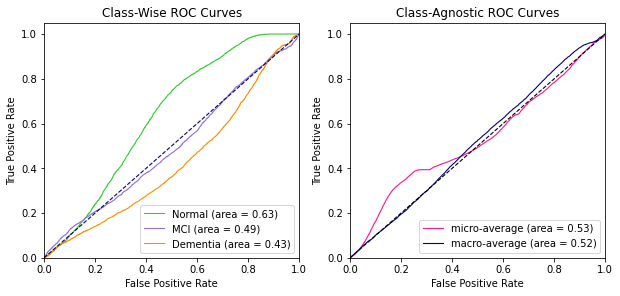

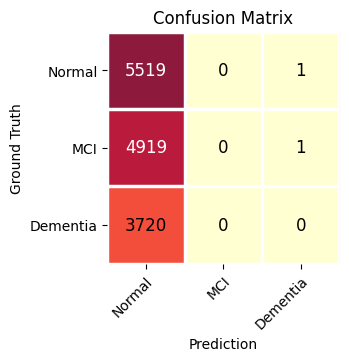


******************************    Configurations for Train    ******************************

{'EKG': 'X',
 '_target_': 'models.resnet_1d.ResNet1D',
 'activation': 'gelu',
 'age_mean': tensor([71.1417]),
 'age_std': tensor([9.7840]),
 'awgn': 0,
 'awgn_age': 0,
 'base_channels': 64,
 'base_lr': 0.00046936536527944847,
 'base_model': '2s1700lg',
 'block': 'basic',
 'channel_difference': [0, 2],
 'channel_survive': 'Fp1 - C3',
 'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'conv_layers': [2, 2, 2, 2],
 'criterion': 'multi-bce',
 'crop_multiple': 4,
 'crop_timing_analysis': False,
 'dataset_name': 'CAUEEG dataset',
 'dataset_path': 'local/dataset/caueeg-dataset/',
 'ddp': False,
 'device': device(type='cuda', index=0),
 'draw_result': True,
 'dropout': 0.3,
 'fc_stages': 3,
 'file_format': 'memmap',
 'in_channels': 1,
 'input_norm': 'dataset',
 'latency': 2000,
 'load_event': False,
 'lr_scheduler_type': 'cosine_dec

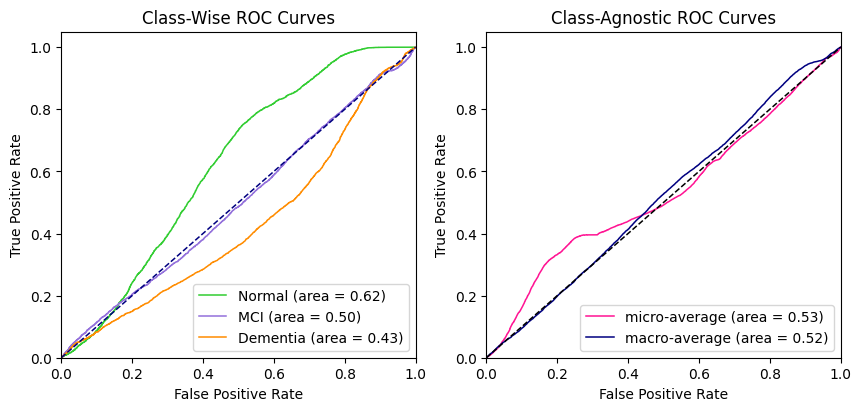

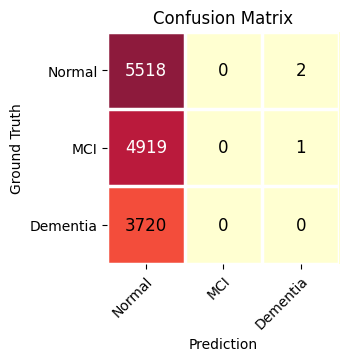


******************************    Configurations for Train    ******************************

{'EKG': 'X',
 '_target_': 'models.resnet_1d.ResNet1D',
 'activation': 'gelu',
 'age_mean': tensor([71.1417]),
 'age_std': tensor([9.7840]),
 'awgn': 0,
 'awgn_age': 0,
 'base_channels': 64,
 'base_lr': 0.00046936536527944847,
 'base_model': '2s1700lg',
 'block': 'basic',
 'channel_difference': [0, 3],
 'channel_survive': 'Fp1 - P3',
 'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'conv_layers': [2, 2, 2, 2],
 'criterion': 'multi-bce',
 'crop_multiple': 4,
 'crop_timing_analysis': False,
 'dataset_name': 'CAUEEG dataset',
 'dataset_path': 'local/dataset/caueeg-dataset/',
 'ddp': False,
 'device': device(type='cuda', index=0),
 'draw_result': True,
 'dropout': 0.3,
 'fc_stages': 3,
 'file_format': 'memmap',
 'in_channels': 1,
 'input_norm': 'dataset',
 'latency': 2000,
 'load_event': False,
 'lr_scheduler_type': 'cosine_dec

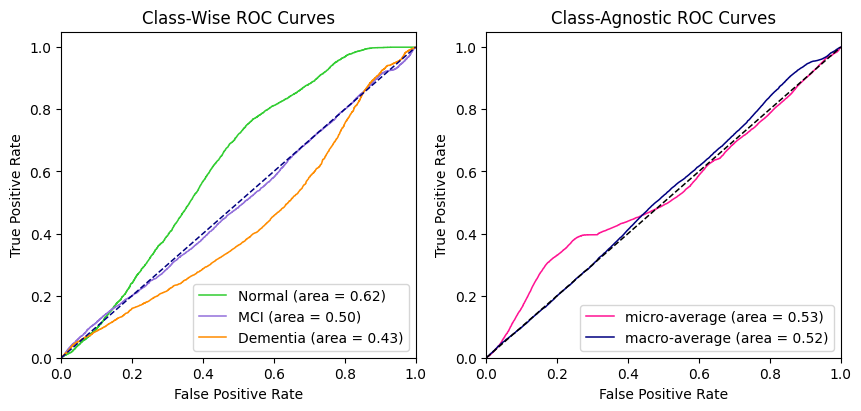

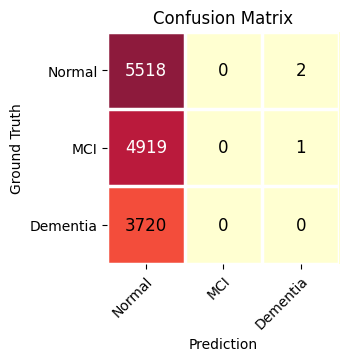


******************************    Configurations for Train    ******************************

{'EKG': 'X',
 '_target_': 'models.resnet_1d.ResNet1D',
 'activation': 'gelu',
 'age_mean': tensor([71.1417]),
 'age_std': tensor([9.7840]),
 'awgn': 0,
 'awgn_age': 0,
 'base_channels': 64,
 'base_lr': 0.00046936536527944847,
 'base_model': '2s1700lg',
 'block': 'basic',
 'channel_difference': [0, 4],
 'channel_survive': 'Fp1 - O1',
 'class_label_to_name': ['Normal', 'MCI', 'Dementia'],
 'class_name_to_label': {'Dementia': 2, 'MCI': 1, 'Normal': 0},
 'conv_layers': [2, 2, 2, 2],
 'criterion': 'multi-bce',
 'crop_multiple': 4,
 'crop_timing_analysis': False,
 'dataset_name': 'CAUEEG dataset',
 'dataset_path': 'local/dataset/caueeg-dataset/',
 'ddp': False,
 'device': device(type='cuda', index=0),
 'draw_result': True,
 'dropout': 0.3,
 'fc_stages': 3,
 'file_format': 'memmap',
 'in_channels': 1,
 'input_norm': 'dataset',
 'latency': 2000,
 'load_event': False,
 'lr_scheduler_type': 'cosine_dec

In [ ]:
channel_nums = range(19)
for channel_difference in tqdm(list(itertools.combinations(channel_nums, 2))):
    add_configs = deepcopy(add_configs_base)

    with hydra.initialize(config_path="../config"):
        cfg = hydra.compose(config_name="default", overrides=add_configs)

    config = {
        **OmegaConf.to_container(cfg.data),
        **OmegaConf.to_container(cfg.train),
        **OmegaConf.to_container(cfg.model),
    }
    config['channel_difference'] = [*channel_difference]
    config['EKG'] = "X"
    config['photic'] = "X"
    config['montage'] = ' - '.join([signal_header[i].split('-')[0] for i in channel_difference])
    config['device'] = 'cuda:0'
    config['use_wandb'] = False
    config['total_samples'] = 5000


    check_device_env(config)
    # pprint.pprint(config)
    prepare_and_run_train(rank=None, world_size=None, config=config)